### 优化器： AdamW  


#### 1.本质
优化器的核心任务是执行梯度下降，使得损失函数最小

#### 2.演变  
- SGD：随机梯度下降 
  - 最基础的更新策略，没有任何记忆，完全依赖当前梯度
  - 公式：$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$
  - 震荡：如果梯度方向变化剧烈，SGD会收敛极慢
  - 停滞：如果梯度很小，更新量会趋近于0 
- Momentum：动量法
  - 让参数更新不仅依赖当前梯度，还保留一部分之前的速度
  - 公式：$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$; 
  - $v_{t+1} = \beta v_t + \nabla L(\theta_t)$
  - 局部最优解：当前梯度为0，靠着历史惯性，还能继续下降  
  - 抑制震荡：震荡方向的梯度正负相消，主路方向的梯度不断累积，速度越来越快

- RMSProp（均方根传播）
  - 在陡峭的地方下降较慢，在平坦的地方下降较快
  - 公式：$\theta_{t+1} = \theta_t - \eta \frac{\sqrt{\hat{g}_t + \epsilon}}{\hat{g}_t + \epsilon} \nabla L(\theta_t)$
  - 实现了参数的自适应学习率。不同的参数可以有不同的更新速度
- Adam
  - 既有一阶矩，又有自适应步长（二阶矩），并加入了偏差修正  
  - 完整流程
    - 计算一阶矩：$\hat{g}_t = \frac{\sum_{i=1}^t g_i}{t}$
    - 计算二阶矩：$\hat{m}_t = \frac{\sum_{i=1}^t g_i^2}{t}$
    - 偏差修正：$\hat{g}_t = \frac{\hat{g}_t}{1 - \beta_1^t}$
    - 更新参数：$\theta_{t+1} = \theta_t - \eta \frac{\hat{g}_t}{\sqrt{\hat{m}_t + \epsilon}}$
  - 但是Adam在处理权重衰减时存在严重的错误，会造成耦合灾难
- AdamW
  - Adam的改进版。让权重衰减独立于梯度更新，单独执行
  - 公式:
    - 先按标准的Adam计算梯度步长：$\theta_{t+1} = \theta_t - \eta \frac{\hat{g}_t}{\sqrt{\hat{m}_t + \epsilon}}$
    - 再按权重衰减更新参数：$\theta_{t+1} = \theta_{t+1} - \eta \lambda \theta_{t+1}$

#### 3.权重衰减
权重衰减在训练时必须开启  
1）防止记忆过载：如果权重非常大，模型就会更加敏感。输入中的噪声经过大权重的放大，会导致输出发生剧烈的改变。**权重衰减强迫模型用更小的权重解决问题，从而使得学习学习规律，而不是记住噪音**  

2）提高数值稳定：每一层的权重都很大时，信号在传递过程中会指数级膨胀，导致溢出。**权重衰减可以将参数控制在合理范围内**  

3）增加泛化能力：我们倾向于选择更简单的模型。因此，权重更小的模型，在数学上等价于简单的函数

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
#中文显示，负号显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [4]:
class AdamW:
 
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        """
        参数说明：
            params: 待优化的参数列表（torch.nn.Parameter）
            lr: 学习率
            betas: (β1, β2) 一阶和二阶矩的衰减系数
            eps: 防止分母为0的小常数
            weight_decay: 权重衰减系数（L2正则）
        """
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        # 初始化一阶矩（动量）和二阶矩（梯度平方的移动平均）
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0  # 时间步（迭代次数）

    def step(self):
        """执行一次参数更新"""
        self.t += 1
        beta1_t = self.beta1 ** self.t
        beta2_t = self.beta2 ** self.t
        
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            
            grad = p.grad.data
            
            # 1. 权重衰减（先应用L2正则）
            if self.weight_decay != 0:
                grad = grad.add(p.data, alpha=self.weight_decay)
            
            # 2. 更新一阶矩（动量）: m_t = β1*m_{t-1} + (1-β1)*g_t
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            
            # 3. 更新二阶矩: v_t = β2*v_{t-1} + (1-β2)*g_t^2
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad * grad
            
            # 4. 偏差修正
            m_hat = self.m[i] / (1 - beta1_t)
            v_hat = self.v[i] / (1 - beta2_t)
            
            # 5. 参数更新: θ_t = θ_{t-1} - lr * m_hat / (√v_hat + ε)
            p.data = p.data - self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        """清空梯度"""
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

初始参数 - w: -0.5672, b: -0.5706


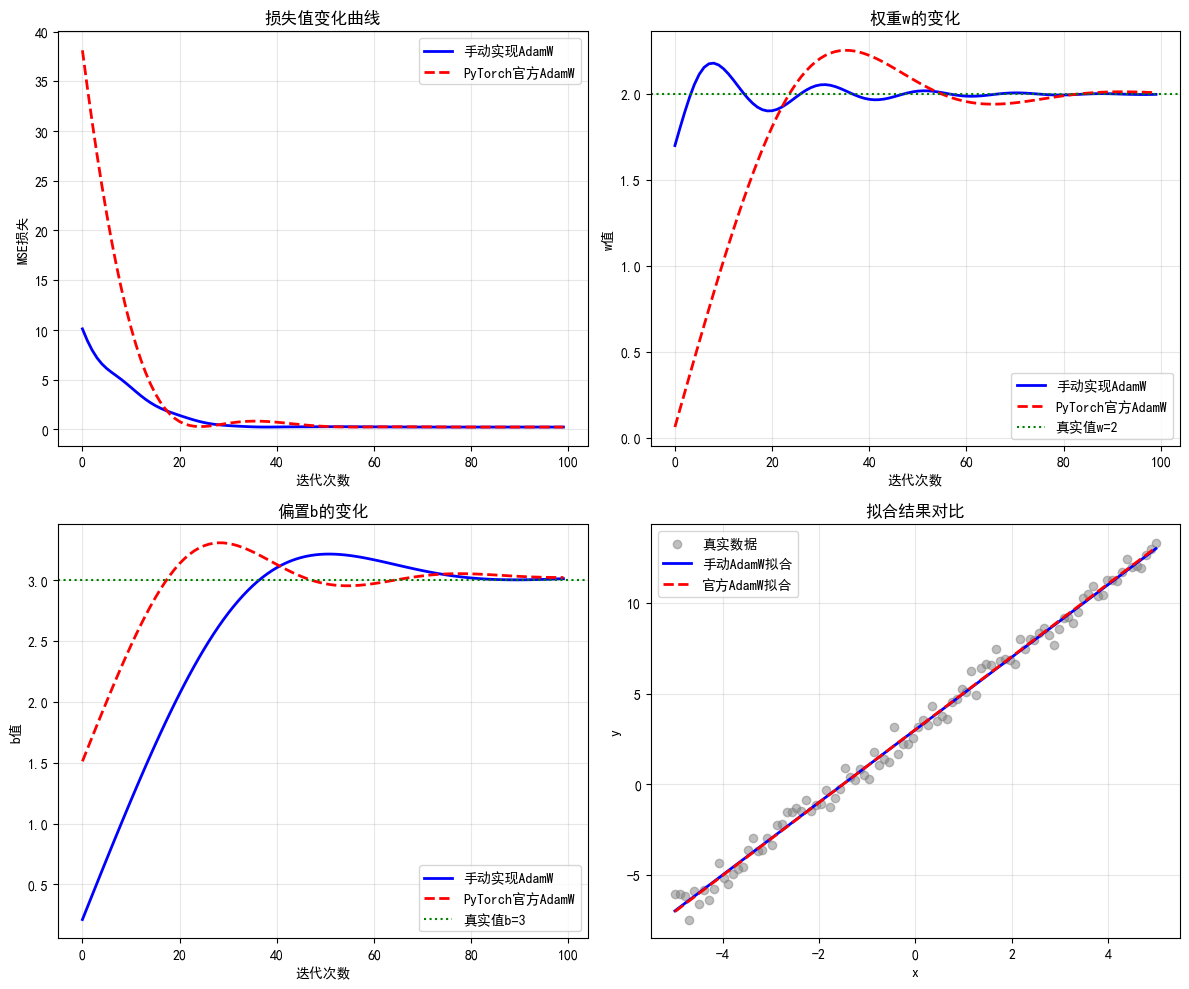


=== 训练结果 ===
手动AdamW - 最终w: 1.9958, 最终b: 3.0110, 最终损失: 0.2412
官方AdamW - 最终w: 2.0056, 最终b: 3.0207, 最终损失: 0.2416
真实值 - w=2, b=3


In [ ]:
def test_adamw_optimizer():
    # 定义优化目标：拟合 y = 2x + 3 的线性函数（带噪声）
    # 生成训练数据
    np.random.seed(42)
    torch.manual_seed(42)
    
    x = torch.linspace(-5, 5, 100).unsqueeze(1)  # [100, 1]
    y_true = 2 * x + 3 + torch.randn_like(x) * 0.5  # 加入噪声
    
    # 定义简单的线性模型
    class LinearModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.w = torch.nn.Parameter(torch.randn(1, 1))  # 权重，初始随机
            self.b = torch.nn.Parameter(torch.randn(1))     # 偏置，初始随机
        
        def forward(self, x):
            return x @ self.w + self.b
    
    model = LinearModel()
    print(f"初始参数 - w: {model.w.item():.4f}, b: {model.b.item():.4f}")
    
    # 定义损失函数（MSE）
    criterion = torch.nn.MSELoss()
    
    # 初始化优化器（手动实现的AdamW vs PyTorch官方AdamW）
    optimizer_manual = AdamW(model.parameters(), lr=0.1, weight_decay=0.001)
    optimizer_official = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=0.001)
    
    # 训练过程（分别用手动和官方AdamW优化）
    epochs = 100
    # 记录训练过程
    loss_history_manual = []
    loss_history_official = []
    w_history_manual = []
    b_history_manual = []
    w_history_official = []
    b_history_official = []
    
    # 手动实现的AdamW训练
    model_manual = LinearModel()  # 重新初始化模型
    optimizer_manual = AdamW(model_manual.parameters(), lr=0.1, weight_decay=0.001)
    for epoch in range(epochs):
        # 前向传播
        y_pred = model_manual(x)
        loss = criterion(y_pred, y_true)
        
        # 反向传播
        optimizer_manual.zero_grad()
        loss.backward()
        optimizer_manual.step()
        
        # 记录数据
        loss_history_manual.append(loss.item())
        w_history_manual.append(model_manual.w.item())
        b_history_manual.append(model_manual.b.item())
    
    # PyTorch官方AdamW训练
    model_official = LinearModel()  # 重新初始化模型
    optimizer_official = torch.optim.AdamW(model_official.parameters(), lr=0.1, weight_decay=0.001)
    for epoch in range(epochs):
        # 前向传播
        y_pred = model_official(x)
        loss = criterion(y_pred, y_true)
        
        # 反向传播
        optimizer_official.zero_grad()
        loss.backward()
        optimizer_official.step()
        
        # 记录数据
        loss_history_official.append(loss.item())
        w_history_official.append(model_official.w.item())
        b_history_official.append(model_official.b.item())
    
    # 可视化结果
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 损失曲线对比
    axes[0,0].plot(loss_history_manual, label='手动实现AdamW', color='blue', linewidth=2)
    axes[0,0].plot(loss_history_official, label='PyTorch官方AdamW', color='red', linestyle='--', linewidth=2)
    axes[0,0].set_title('损失值变化曲线')
    axes[0,0].set_xlabel('迭代次数')
    axes[0,0].set_ylabel('MSE损失')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 权重w的变化曲线
    axes[0,1].plot(w_history_manual, label='手动实现AdamW', color='blue', linewidth=2)
    axes[0,1].plot(w_history_official, label='PyTorch官方AdamW', color='red', linestyle='--', linewidth=2)
    axes[0,1].axhline(y=2, color='green', linestyle=':', label='真实值w=2')
    axes[0,1].set_title('权重w的变化')
    axes[0,1].set_xlabel('迭代次数')
    axes[0,1].set_ylabel('w值')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 偏置b的变化曲线
    axes[1,0].plot(b_history_manual, label='手动实现AdamW', color='blue', linewidth=2)
    axes[1,0].plot(b_history_official, label='PyTorch官方AdamW', color='red', linestyle='--', linewidth=2)
    axes[1,0].axhline(y=3, color='green', linestyle=':', label='真实值b=3')
    axes[1,0].set_title('偏置b的变化')
    axes[1,0].set_xlabel('迭代次数')
    axes[1,0].set_ylabel('b值')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 最终拟合结果对比
    x_np = x.numpy()
    y_true_np = y_true.numpy()
    y_pred_manual = model_manual(x).detach().numpy()
    y_pred_official = model_official(x).detach().numpy()
    
    axes[1,1].scatter(x_np, y_true_np, alpha=0.5, label='真实数据', color='gray')
    axes[1,1].plot(x_np, y_pred_manual, label='手动AdamW拟合', color='blue', linewidth=2)
    axes[1,1].plot(x_np, y_pred_official, label='官方AdamW拟合', color='red', linestyle='--', linewidth=2)
    axes[1,1].set_title('拟合结果对比')
    axes[1,1].set_xlabel('x')
    axes[1,1].set_ylabel('y')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('adamw_optimization_result.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    print("\n=== 训练结果 ===")
    print(f"手动AdamW - 最终w: {model_manual.w.item():.4f}, 最终b: {model_manual.b.item():.4f}, 最终损失: {loss_history_manual[-1]:.4f}")
    print(f"官方AdamW - 最终w: {model_official.w.item():.4f}, 最终b: {model_official.b.item():.4f}, 最终损失: {loss_history_official[-1]:.4f}")
    print(f"真实值 - w=2, b=3")

# 运行测试
if __name__ == "__main__":
    test_adamw_optimizer()

左上角：损失曲线（手动和官方 AdamW 几乎重合，损失快速下降）  

右上角：权重 w 的变化（从随机值快速收敛到 2）  

左下角：偏置 b 的变化（从随机值快速收敛到 3）  

右下角：拟合曲线（几乎和真实数据趋势一致）